In [3]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec
import math
import scipy.ndimage.filters as filters 

In [4]:


def plot_shower_data(file_path, filter_energy=60, threshold_energy=5):
    with h5py.File(file_path, 'r') as f:
        
        #importing the total energy per shower
        dataset_genE = f['genE']
        data_genE = dataset_genE[:]
        energy_total = data_genE[:]
    
        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
        
        #extracting the size of the showers
        size_of_event = len(data_showers[0])
        
        # Filter the data based on energy range
        is_in_range = np.abs(energy_total - filter_energy) <= threshold_energy
        selected_indices = np.where(is_in_range)[0]
        filtered_data = data_showers[selected_indices]
        
        # Extract coordinates and energies
        x_complete, y_complete, z_complete, energy_xyz_complete = [filtered_data[:, :, i] for i in range(4)]
        x = x_complete[x_complete != 0]
        y = y_complete[y_complete != 0]
        z = z_complete[z_complete != 0]
        xyz_bin_min = min(x)
        xyz_bin_max = max(x)+2
        
        energy_xyz = energy_xyz_complete[energy_xyz_complete > 0]
        
        # Convert energy to MeV
        energy_total_mev = energy_total * 1000
        
        # Plotting the distributions
        fig = plt.figure(figsize=(18, 12), facecolor='white')
        fig.suptitle(f'Projected {filter_energy}GeV Showers', fontsize=30)
        gs = GridSpec(2, 3)

        # Energy Histogram
        ax0 = fig.add_subplot(gs[0])
        ax0.set_title('Visible Energy')
        ax0.hist(energy_xyz, bins=np.logspace(np.log(0.1), np.log(max(energy_xyz)), 150, base=np.e), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax0.set_xlabel('Visible energy (MeV)')
        ax0.set_ylabel('a.u.')
        ax0.set_xscale('log')
        ax0.set_yscale('log')

        # Energy Sum Histogram
        ax1 = fig.add_subplot(gs[1])
        ax1.set_title('Energy Sum')
        ax1.hist(energy_xyz_complete.reshape(-1, size_of_event).sum(-1), bins=50, histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax1.set_xlabel('Visible energy sum (MeV)')
        ax1.set_ylabel('a.u.')

        # Number of Hits Histogram
        ax2 = fig.add_subplot(gs[2])
        ax2.set_title('Number of Hits')
        n_hits = (energy_xyz_complete != 0).reshape(-1, size_of_event).sum(axis=1)
        ax2.hist(n_hits, bins=50, histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax2.set_xlabel('n_hits')
        ax2.set_ylabel('a.u.')

        step =  math.ceil(xyz_bin_max/11)
        # X Distribution
        ax3 = fig.add_subplot(gs[3])
        ax3.set_title('[X] distribution')
        ax3.hist(x, bins=np.arange(xyz_bin_min, xyz_bin_max), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax3.set_xlabel('X')
        ax3.set_ylabel('Number of hits')
        ax3.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        # Y Distribution
        ax4 = fig.add_subplot(gs[4])
        ax4.set_title('[Y] distribution')
        ax4.hist(y, bins=np.arange(xyz_bin_min, xyz_bin_max), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax4.set_xlabel('Y')
        ax4.set_ylabel('Number of hits')
        ax4.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        # Z Distribution
        ax5 = fig.add_subplot(gs[5])
        ax5.set_title('[Z] distribution')
        ax5.hist(z, bins=np.arange(xyz_bin_min, xyz_bin_max), histtype='stepfilled', lw=2, alpha=1., color='silver')
        ax5.set_xlabel('Z')
        ax5.set_ylabel('Number of hits')
        ax5.set_xticks(np.arange(xyz_bin_min, xyz_bin_max,step))

        fig.tight_layout()
        plt.show()
        fig.savefig(f'./plots/{filter_energy}GeV_showers_{size_of_event}_points.pdf')


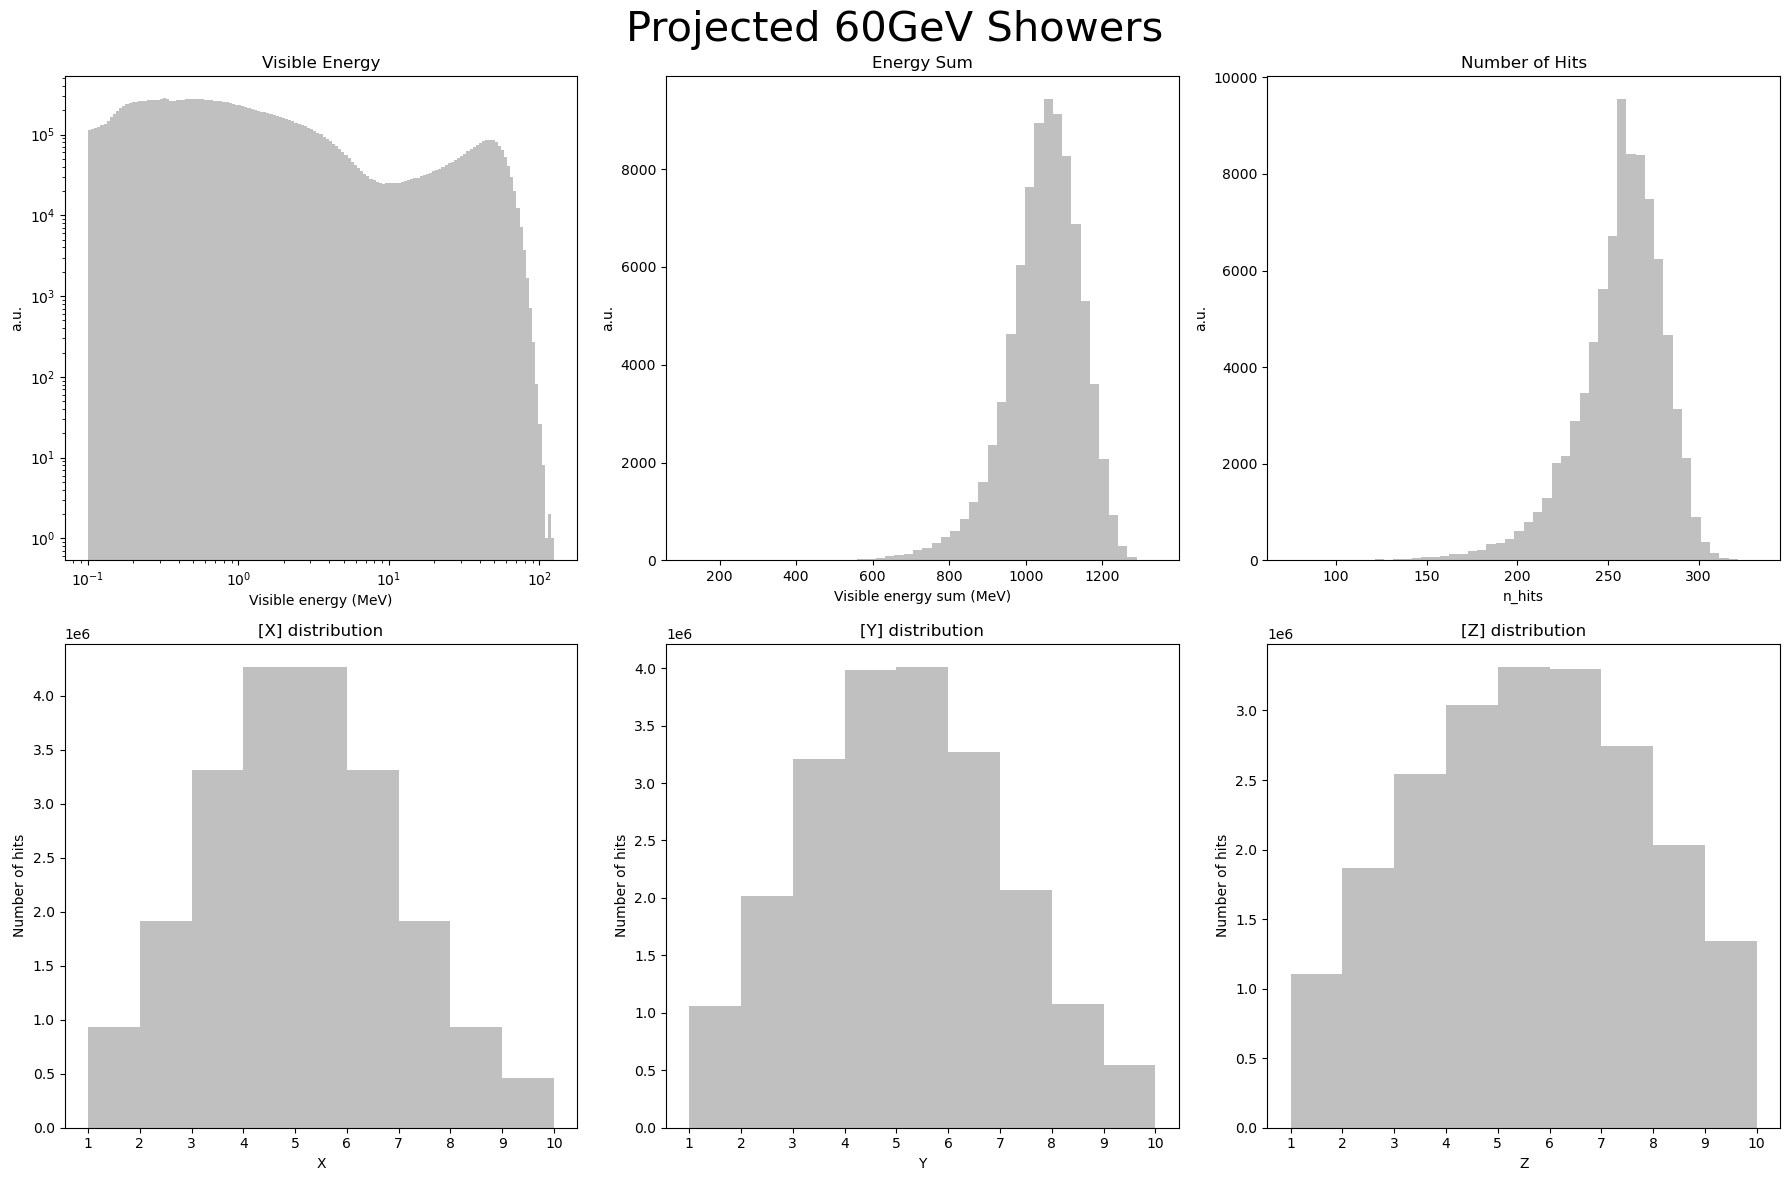

In [5]:
#Plot for the 500 event showers
file_path_500 = '/beegfs/desy/user/korcariw/multiRes_CaloClouds/dataset/showers/photons_10_100GeV_10bins_showers_train.h5'
plot_shower_data(file_path_500)

In [6]:
#Plot for the 1700 event showers
file_path_1700 = '/beegfs/desy/user/korcariw/CaloClouds/dataset/showers/photons_10_100GeV_float32_sorted_train.h5'
plot_shower_data(file_path_1700)


In [ ]:
def threedplot(file_path,event_number):
    with h5py.File(file_path, 'r') as f:

        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
        
    shower = data_showers[event_number]
    
    x, y, z, e = [shower[ :, i] for i in range(4)]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(z, y, x, c=e, cmap='viridis') 
    ax.set_xlabel('Z')
    ax.set_ylabel('Y')
    ax.set_zlabel('X')
    ax.view_init(elev=15, azim=-80)
    
    # Add a colorbar
    norm = plt.Normalize(e.min(), e.max())  
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm) 
    sm.set_array([]) 
    fig.colorbar(sm, label='Energy in MeV') 

    
    fig.tight_layout()
    fig.savefig('./plots/threedplot.pdf')
    


/tmp/ipykernel_43548/1592796281.py:25: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(sm, label='Energy in MeV')


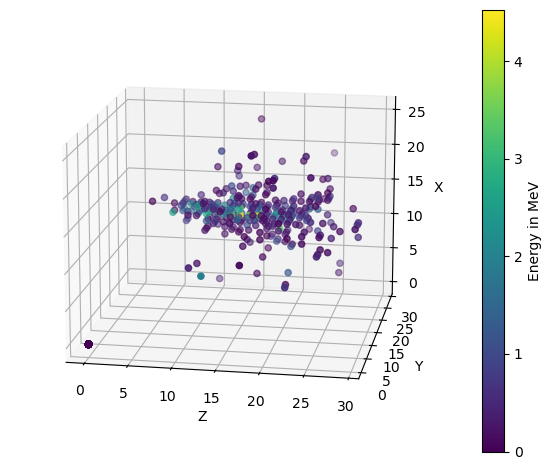

In [ ]:
threedplot(file_path_1700,2000)

In [ ]:
def plot_shower_heatmap(file_path, filter_energy=60, threshold_energy=1):
    with h5py.File(file_path, 'r') as f:
        
        #importing the total energy per shower
        dataset_genE = f['genE']
        data_genE = dataset_genE[:]
        energy_total = data_genE[:]
    
        
        #importing the showers
        dataset_showers = f['showers']
        data_showers = dataset_showers[:]
    #extracting the size of the showers
    size_of_event = len(data_showers[0])
    
    # Filter the data based on energy range
    is_in_range = np.abs(energy_total - filter_energy) <= threshold_energy
    selected_indices = np.where(is_in_range)[0]
    filtered_data = data_showers[selected_indices]
    
    # Extract coordinates and energies
    x, y, z, energy = [filtered_data[:, :, i] for i in range(4)]
    x,y,z,energy = x.flatten(), y.flatten(), z.flatten(), energy.flatten()
    
    heatmap_xy = np.zeros((int(max(y)+1),int(max(y)+1)))
    heatmap_zy = np.zeros((int(max(y)+1),int(max(y)+1)))
    heatmap_zx = np.zeros((int(max(y)+1),int(max(y)+1)))
    
    # Fill heatmap with energy values
    for i in range(len(x)):
        heatmap_xy[int(y[i]), int(x[i])] += energy[i]
        heatmap_zy[int(z[i]), int(y[i])] += energy[i]
        heatmap_zx[int(z[i]), int(x[i])] += energy[i]

    sigma = 1.5  # moothing strength (increase for more blur)
    
    # Plot each heatmap
    fig, (ax_xy, ax_xz, ax_zy) = plt.subplots(1, 3, figsize=(15, 5))
    
    # List of heatmaps and corresponding axes
    heatmaps = [heatmap_xy, heatmap_zx, heatmap_zy]
    axes = [ax_xy, ax_xz, ax_zy]
    
    for heatmap, ax in zip(heatmaps, axes):
        smoothed_heatmap = filters.gaussian_filter(heatmap, sigma)
        im = ax.imshow(smoothed_heatmap, origin='lower')
    
    
        # Set labels and titles for each subplot
        if ax == ax_xy:
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title('XY')
        elif ax == ax_xz:
            ax.set_xlabel('X')
            ax.set_ylabel('Z')
            ax.set_title('XZ')
        elif ax == ax_zy:
            ax.set_xlabel('Y')
            ax.set_ylabel('Z')
            ax.set_title('YZ')
            
    fig.suptitle(f'Proint level distribution of {filter_energy}GeV Showers', fontsize=30)
    # Improve spacing and display the plot
    plt.tight_layout()
    plt.show()
    fig.savefig(f'./plots/{filter_energy}GeV_{size_of_event}_pointlvl_distribution_.pdf')
    


In [ ]:
plot_shower_heatmap(file_path_1700)

NameError: name 'file_path_1700' is not defined